In [19]:
import numpy as np
import pandas as pd
import keras
import tensorflow as tf
import sklearn
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate
from tensorflow.keras.models import Model
import segmentation_models as sm
from glob import glob
import os
import sys

In [2]:
metadata = pd.read_csv("metadata.csv")
metadata

,image_id,split,sat_image_path,mask_path
0,100694,train,train/100694_sat.jpg,train/100694_mask.png
1,102122,train,train/102122_sat.jpg,train/102122_mask.png
2,10233,train,train/10233_sat.jpg,train/10233_mask.png
3,103665,train,train/103665_sat.jpg,train/103665_mask.png
4,103730,train,train/103730_sat.jpg,train/103730_mask.png
...,...,...,...,...
1141,979233,test,test/979233_sat.jpg,NaN
1142,983689,test,test/983689_sat.jpg,NaN
1143,988205,test,test/988205_sat.jpg,NaN
1144,989953,test,test/989953_sat.jpg,NaN


In [3]:
metadata['split'].value_counts()

train    803
test     172
valid    171
Name: split, dtype: int64

In [4]:
train_path = metadata[metadata['split'] == 'train']
test_path = metadata[metadata['split'] == 'test']
valid_path = metadata[metadata['split'] == 'valid']
train_path

,image_id,split,sat_image_path,mask_path
0,100694,train,train/100694_sat.jpg,train/100694_mask.png
1,102122,train,train/102122_sat.jpg,train/102122_mask.png
2,10233,train,train/10233_sat.jpg,train/10233_mask.png
3,103665,train,train/103665_sat.jpg,train/103665_mask.png
4,103730,train,train/103730_sat.jpg,train/103730_mask.png
...,...,...,...,...
798,992507,train,train/992507_sat.jpg,train/992507_mask.png
799,994520,train,train/994520_sat.jpg,train/994520_mask.png
800,995492,train,train/995492_sat.jpg,train/995492_mask.png
801,997521,train,train/997521_sat.jpg,train/997521_mask.png


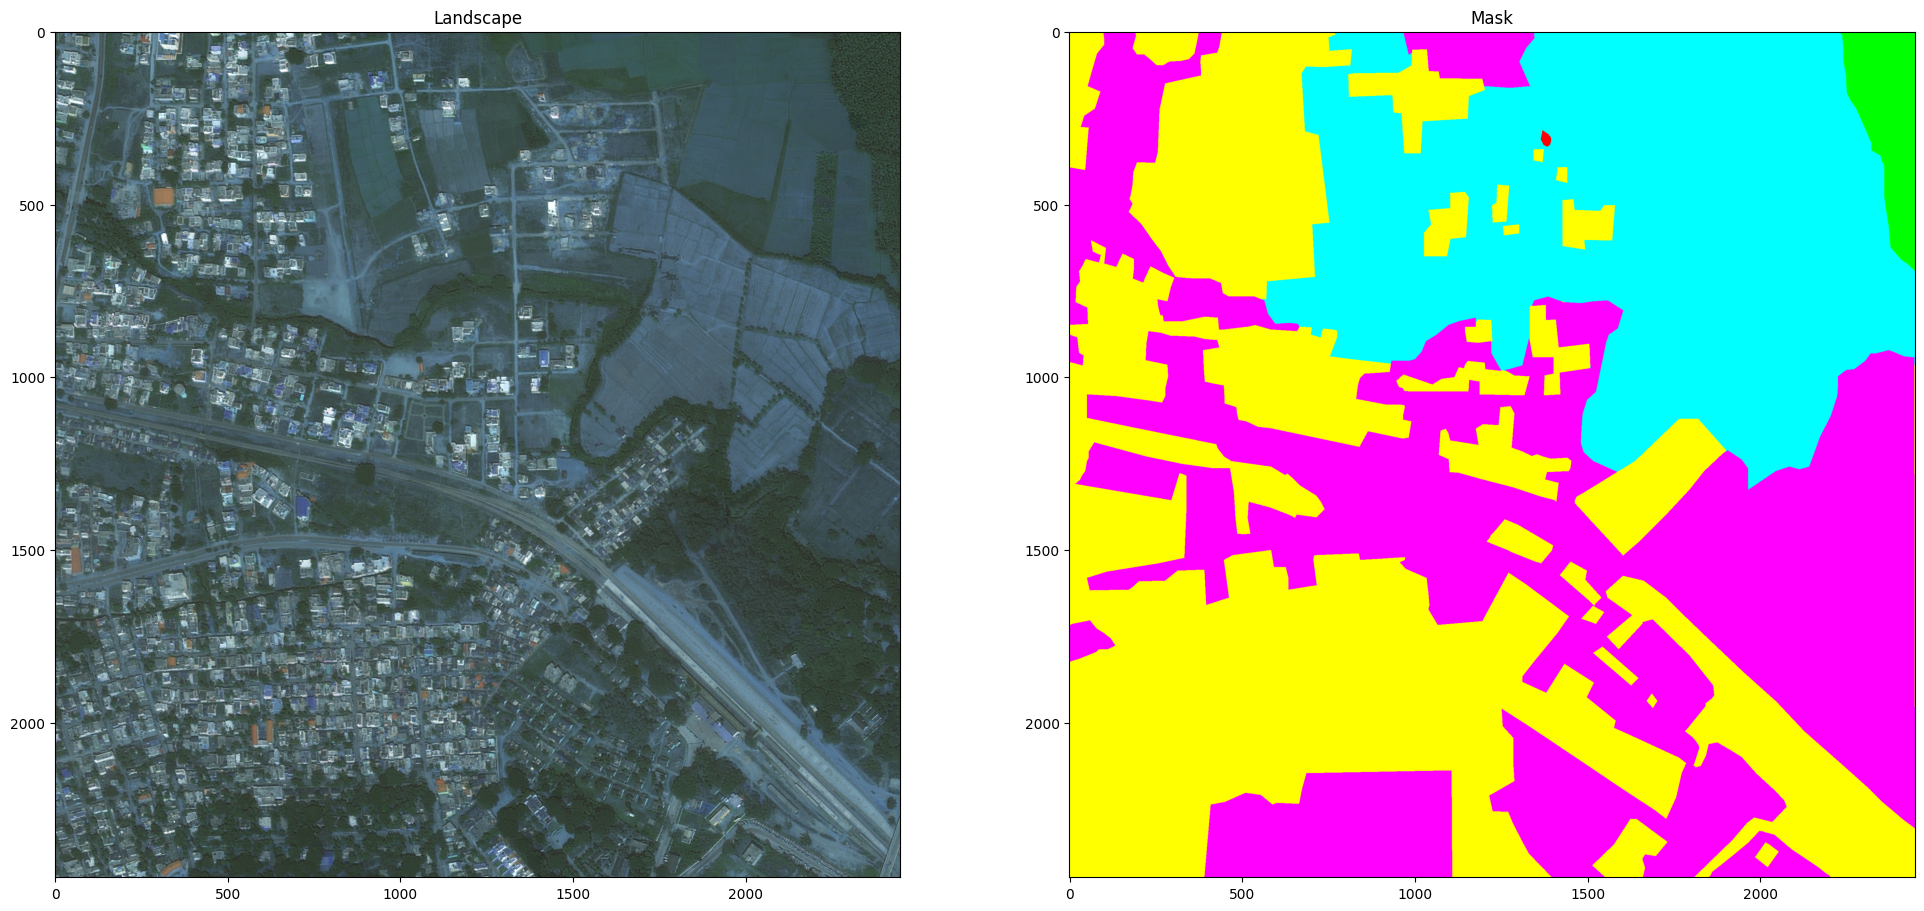

In [5]:
img = cv2.imread(train_path['sat_image_path'][6])
mask = cv2.imread(train_path['mask_path'][6])
plt.figure(figsize=(24,24))

plt.subplot(121)
plt.title('Landscape')
plt.imshow(img)

plt.subplot(122)
plt.title('Mask')
plt.imshow(mask)

In [5]:
class_data = pd.read_csv('class_dict.csv')
class_data

,name,r,g,b
0,urban_land,0,255,255
1,agriculture_land,255,255,0
2,rangeland,255,0,255
3,forest_land,0,255,0
4,water,0,0,255
5,barren_land,255,255,255
6,unknown,0,0,0


In [6]:
class_data[['r','g','b']].to_numpy()

array([[  0, 255, 255],
       [255, 255,   0],
       [255,   0, 255],
       [  0, 255,   0],
       [  0,   0, 255],
       [255, 255, 255],
       [  0,   0,   0]], dtype=int64)

In [7]:
map_color = {k:v for k,v in zip(class_data.index,class_data[['r','g','b']].to_numpy().tolist())}
map_color

{0: [0, 255, 255],
 1: [255, 255, 0],
 2: [255, 0, 255],
 3: [0, 255, 0],
 4: [0, 0, 255],
 5: [255, 255, 255],
 6: [0, 0, 0]}

In [8]:
datagen = ImageDataGenerator()
train_img = datagen.flow_from_dataframe(
    dataframe = train_path,
    train_dir = None,
    x_col='sat_image_path',
    batch_size = 32,
    seed = 24,
    class_mode = None
)

train_mask = datagen.flow_from_dataframe(
    dataframe = train_path,
    train_dir = None,
    x_col='mask_path',
    batch_size = 32,
    seed = 24,
    class_mode = None
)

test_img = datagen.flow_from_dataframe(
    dataframe = test_path,
    train_dir = None,
    x_col='sat_image_path',
    batch_size = 32,
    seed = 24,
    class_mode = None
)

valid_img = datagen.flow_from_dataframe(
    dataframe = valid_path,
    train_dir = None,
    x_col='sat_image_path',
    batch_size = 32,
    seed = 24,
    class_mode = None
)

Found 803 validated image filenames.
Found 803 validated image filenames.
Found 172 validated image filenames.
Found 171 validated image filenames.


In [15]:
dataset = tf.data.Dataset.from_generator(lambda : (train_img,train_mask),output_types=(tf.float32, tf.float32), 
    output_shapes=([32,256,256,3], [32,5]))

In [20]:
sys.getsizeof(dataset)

48

In [15]:
with tf.device("CPU"):
    def shuffling(x, y):
        x, y = shuffle(x, y, random_state=42)
        return x, y

    def load_data():
        x = sorted(glob('train/*_sat.jpg'))
        y = sorted(glob('train/*_mask.png'))
        return x, y

    def read_image(path):
        path = path.decode()
        x = cv2.imread(path, cv2.IMREAD_COLOR)
        x = x/255.0
        x = x.astype(np.float32)
        return x

    def read_mask(path):
        path = path.decode()
        x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        x = x.astype(np.float32)
        x = np.expand_dims(x, axis=-1)
        return x

    def tf_parse(x, y):
        def _parse(x, y):
            x = read_image(x)
            y = read_mask(y)
            return x, y

        x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
        return x, y

    def tf_dataset(X, Y, batch=2):
        dataset = tf.data.Dataset.from_tensor_slices((X, Y))
        dataset = dataset.map(tf_parse)
        dataset = dataset.batch(batch)
        dataset = dataset.prefetch(10)
        return dataset

    X,Y = load_data()
    dataset = tf_dataset(X,Y,2)
    print(*dataset)

: 

: 

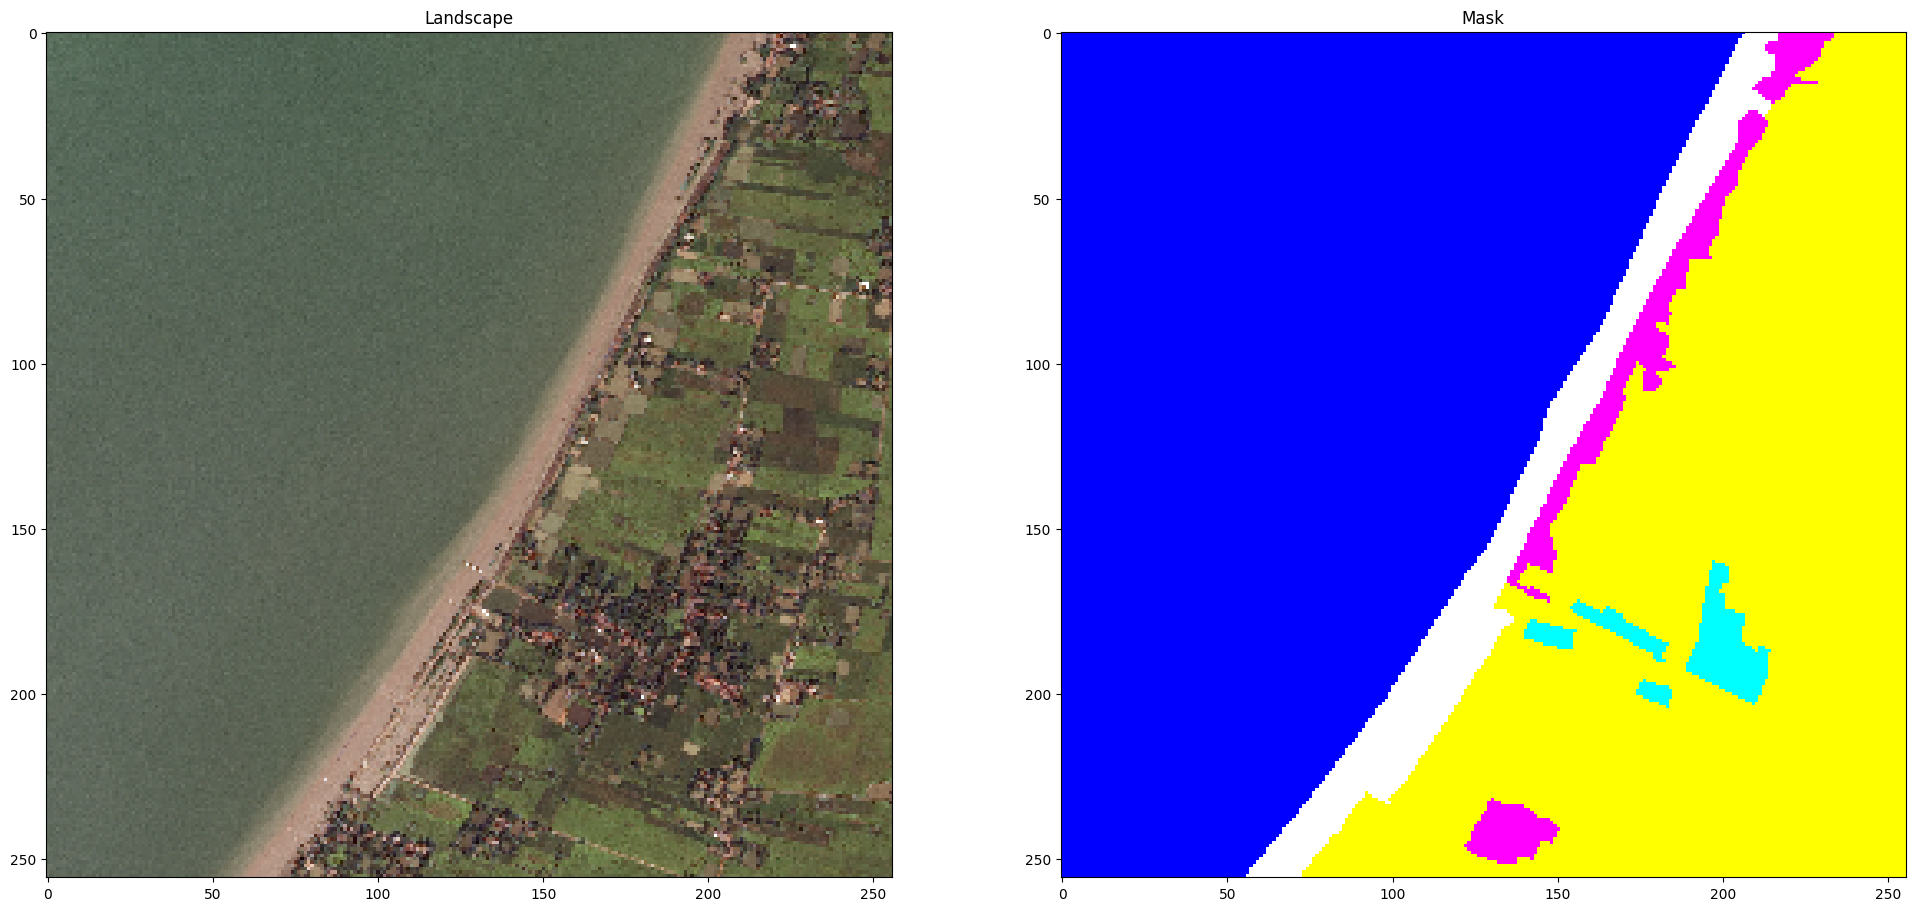

In [12]:
plt.figure(figsize=(24,24))

plt.subplot(121)
plt.title('Landscape')
plt.imshow(train_img[0][0].astype('int64'))

plt.subplot(122)
plt.title('Mask')
plt.imshow(train_mask[0][0].astype('int64'))

In [13]:
def get_unet_model(input_size=(256, 256, 3)):
    inputs = Input(input_size)
    
    # Encoder
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    # Decoder
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    up5 = UpSampling2D(size=(2, 2))(conv4)
    up5 = Conv2D(128, (2, 2), activation='relu', padding='same')(up5)
    merge5 = concatenate([conv3, up5], axis=3)
    
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(merge5)
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv6)
    up7 = UpSampling2D(size=(2, 2))(conv6)
    up7 = Conv2D(64, (2, 2), activation='relu', padding='same')(up7)
    merge7 = concatenate([conv2, up7], axis=3)
    
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(merge7)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
    up9 = UpSampling2D(size=(2, 2))(conv8)
    up9 = Conv2D(32, (2, 2), activation='relu', padding='same')(up9)
    merge9 = concatenate([conv1, up9], axis=3)
    
    conv10 = Conv2D(32, (3, 3), activation='relu', padding='same')(merge9)
    conv10 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv10)
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv10)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

In [16]:
model = sm.Unet('mobilenetv2',input_shape=(256,256,3),classes=7,activation='softmax')
acc_metrics = [tf.keras.metrics.CategoricalAccuracy()]
model.compile(loss=categorical_crossentropy, optimizer='adam',metrics=acc_metrics)

c:\Users\saksh\miniconda3\envs\tf\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [17]:
model.fit(dataset,batch_size=2,epochs=2)

Epoch 1/2


ValueError: in user code:

    File "c:\Users\saksh\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\saksh\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\saksh\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\saksh\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 994, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\saksh\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1052, in compute_loss
        return self.compiled_loss(
    File "c:\Users\saksh\miniconda3\envs\tf\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\saksh\miniconda3\envs\tf\lib\site-packages\keras\losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "c:\Users\saksh\miniconda3\envs\tf\lib\site-packages\keras\losses.py", line 272, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Users\saksh\miniconda3\envs\tf\lib\site-packages\keras\losses.py", line 1990, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "c:\Users\saksh\miniconda3\envs\tf\lib\site-packages\keras\backend.py", line 5529, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (32, 5) and (32, 256, 256, 7) are incompatible
